In [1]:
from google.cloud import bigquery
import pandas as pd
import os
import numpy as np
import shap
from sklearn.metrics import mean_squared_error, mean_absolute_error
import evaluation
from scikeras.wrappers import KerasRegressor
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'tcloud-ga.json'
bq_client = bigquery.Client()

In [2]:
sql_query1 ="""
with orderinfo as(
SELECT sme_ban, sum(sol_price) as total_pay, sum(sol_point) as pointsused , sum(sol_selfpay) as selfpay, sum(solution_duration) servicelen, count(order_num) as ordernums, solution_uuid FROM `tcloud-data-analysis.highly_use_data.orders` 
group by sme_ban,solution_uuid 
),
sme as (
  select * from tcloud-data-analysis.ml_data.sme_basic_numeric
),
page as (
  select * from `tcloud-data-analysis.ga3.solution_pv`
),
ind as (
  select sme_ban, ind_large from `tcloud-data-analysis.tcloud_analytics_iii.sme_basic`
)

select orderinfo.* , sme.* EXCEPT(sme_ban), page.* EXCEPT(clean_path2), ind_large
from orderinfo
join sme on orderinfo.sme_ban = sme.sme_ban
join page on orderinfo.solution_uuid = page.clean_path2
join ind on orderinfo.sme_ban= ind.sme_ban
"""
query_job1 = bq_client.query(sql_query1)
recommend = query_job1.to_dataframe()


In [3]:

query_indnm = """
SELECT * FROM `tcloud-data-analysis.tcloud_analytics_iii.industry_large`
"""

# 查詢資料並將結果存為 DataFrame
query_job = bq_client.query(query_indnm)
industry_df = query_job.to_dataframe()

# 提取所有可能的 ind_large 選項
ind_large_values = industry_df['ind_large'].unique()


query_subcate = """
SELECT * FROM `tcloud-data-analysis.tcloud_analytics_iii.solution_subcategory_encoding`
"""

# 查詢資料並將結果存為 DataFrame
query_job = bq_client.query(query_subcate)
solution_sub = query_job.to_dataframe()

In [4]:
import pandas as pd
from pandas.api.types import CategoricalDtype

# 將 ind_large 轉換為 CategoricalDtype 並指定所有可能的類別
ind_large_type = CategoricalDtype(categories=ind_large_values, ordered=False)
recommend['ind_large'] = recommend['ind_large'].astype(ind_large_type)

# 進行 one-hot encoding
ind_large_dummies = pd.get_dummies(recommend['ind_large'], prefix='ind_large')

# 將所有編碼列轉換為 'Int64' 數據類型
ind_large_dummies = ind_large_dummies.astype('Int64')

# 合併原始 DataFrame 和編碼後的 DataFrame
recommend = pd.concat([recommend.drop('ind_large', axis=1), ind_large_dummies], axis=1)
recommend = recommend.merge(solution_sub, on='solution_uuid', how='left')

In [5]:
recommend.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46054 entries, 0 to 46053
Data columns (total 79 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   sme_ban                                 46054 non-null  object
 1   total_pay                               46054 non-null  Int64 
 2   pointsused                              46054 non-null  Int64 
 3   selfpay                                 46054 non-null  Int64 
 4   servicelen                              46054 non-null  Int64 
 5   ordernums                               46054 non-null  Int64 
 6   solution_uuid                           46054 non-null  object
 7   q_organizationsize_level                46054 non-null  Int64 
 8   q_planningtime_level                    46054 non-null  Int64 
 9   q_budget_level                          46054 non-null  Int64 
 10  opscore1                                46054 non-null  object
 11  op

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split

# ...其他程式碼(資料讀取等)...

def create_mappings(df, user_col, item_col):
    user_mapping = {user: idx for idx, user in enumerate(df[user_col].unique())}
    item_mapping = {item: idx for idx, item in enumerate(df[item_col].unique())}
    return user_mapping, item_mapping

def encode_data(df, user_col, item_col, user_mapping, item_mapping):
    df[user_col] = df[user_col].map(user_mapping)
    df[item_col] = df[item_col].map(item_mapping)
    return df

def reverse_mappings(mapping):
    return {idx: key for key, idx in mapping.items()}

def save_mappings(user_reverse_mapping, item_reverse_mapping, user_mapping_filename, item_mapping_filename):
    user_reverse_mapping_df = pd.DataFrame(list(user_reverse_mapping.items()), columns=['encoded', 'original'])
    item_reverse_mapping_df = pd.DataFrame(list(item_reverse_mapping.items()), columns=['encoded', 'original'])
    user_reverse_mapping_df.to_csv(user_mapping_filename, index=False)
    item_reverse_mapping_df.to_csv(item_mapping_filename, index=False)

sme_ban_mapping, solution_uuid_mapping = create_mappings(recommend, 'sme_ban', 'solution_uuid')

recommend_encoded = encode_data(recommend.copy(), 'sme_ban', 'solution_uuid', sme_ban_mapping, solution_uuid_mapping)

sme_ban_reverse_mapping = reverse_mappings(sme_ban_mapping)
solution_uuid_reverse_mapping = reverse_mappings(solution_uuid_mapping)

save_mappings(sme_ban_reverse_mapping, solution_uuid_reverse_mapping, 'sme_ban_reverse_mapping.csv', 'solution_uuid_reverse_mapping.csv')

# 數據分割
train_data, test_data = train_test_split(recommend_encoded, test_size=0.2, random_state=42)
# 欄位分割
sme_ban_columns = [
    'q_organizationsize_level', 'q_planningtime_level', 'q_budget_level',
    'opscore1', 'opscore2', 'marscore1', 'marscore2', 'salescore1', 'salescore2',
    'securscore1', 'securscore2', 'remotescore1', 'remotescore2', 'schedscore1',
    'schedscore2', 'sme_age', 'capital', 'employee_count',
    'ind_large_A', 'ind_large_B', 'ind_large_C', 'ind_large_D',
    'ind_large_E', 'ind_large_F', 'ind_large_G', 'ind_large_H',
    'ind_large_I', 'ind_large_J', 'ind_large_K', 'ind_large_L',
    'ind_large_M', 'ind_large_N', 'ind_large_P', 'ind_large_Q',
    'ind_large_R', 'ind_large_S'
]

solution_uuid_columns = [
    'pageview', 'bound', 'in_site', 'crm_system', 'erp_system', 'pos_integration', 'seo',
    'hr_management', 'credit_card_ticketing', 'survey_analysis',
    'big_data_analysis', 'customer_interaction', 'market_research',
    'digital_advertising', 'document_processing_software',
    'membership_point_system', 'production_logistics_management',
    'carbon_emission_calculation_analysis',
    'community_content_management_operation', 'sms_system',
    'online_customer_service', 'online_meeting', 'online_reservation',
    'energy_management_system', 'mobile_payment',
    'marketing_matchmaking_kol', 'financial_management',
    'information_security', 'public_opinion_analysis',
    'inventory_management_system', 'remote_collaboration',
    'antivirus_software', 'ecommerce_online_shopping_platform',
    'enewsletter_edm', 'electronic_invoice'
]
interaction_columns = ['total_pay']

# 將訓練集和測試集拆分為用戶編碼、物品編碼和交互作用
train_sme_ban = train_data['sme_ban'].astype('int32')
train_solution_uuid = train_data['solution_uuid'].astype('int32')
train_interactions = train_data[interaction_columns].astype('int32')

test_sme_ban = test_data['sme_ban'].astype('int32')
test_solution_uuid = test_data['solution_uuid'].astype('int32')
test_interactions = test_data[interaction_columns].astype('int32')



#interaction_columns = ['sme_ban', 'solution_uuid', 'total_pay', 'pointsused', 'selfpay', 'servicelen', 'ordernums']


# 分別獲取訓練集和測試集中的用戶和物品特徵
train_sme_ban_features = train_data[sme_ban_columns].astype('int32')
train_solution_uuid_features = train_data[solution_uuid_columns].astype('int32')

test_sme_ban_features = test_data[sme_ban_columns].astype('int32')
test_solution_uuid_features = test_data[solution_uuid_columns].astype('int32')


In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

In [8]:
class CustomKerasRegressor(KerasRegressor):
    def __init__(self, *args, **kwargs):
        super(CustomKerasRegressor, self).__init__(*args, **kwargs)

    def fit(self, X, y, **kwargs):
        # 分割特徵矩陣
        sme_ban_features_start = 1
        sme_ban_features_end = sme_ban_features_start + len(sme_ban_columns)
        solution_uuid_features_start = sme_ban_features_end + 1
        solution_uuid_features_end = solution_uuid_features_start + len(solution_uuid_columns)

        train_sme_ban = X[:, 0].reshape(-1, 1)
        train_sme_ban_features = X[:, sme_ban_features_start:sme_ban_features_end]
        train_solution_uuid = X[:, sme_ban_features_end].reshape(-1, 1)
        train_solution_uuid_features = X[:, solution_uuid_features_start:solution_uuid_features_end]

        return super(CustomKerasRegressor, self).fit(
            [train_sme_ban, train_sme_ban_features, train_solution_uuid, train_solution_uuid_features],
            y,
            **kwargs
        )


In [9]:
def create_model(embedding_dim=8, dense_layer_sizes=(128, 64), learning_rate=0.001):
    # SME_BAN 輸入
    sme_ban_input = Input(shape=(1,), name='sme_ban_input')
    sme_ban_embedding = Embedding(input_dim=train_sme_ban.max() + 2, output_dim=embedding_dim, mask_zero=True, name='sme_ban_embedding')(sme_ban_input)
    sme_ban_vec = Flatten()(sme_ban_embedding)

    sme_ban_features_input = Input(shape=(len(sme_ban_columns),), name='sme_ban_features_input')
    sme_ban_combined = Concatenate()([sme_ban_vec, sme_ban_features_input])

    # Solution_UUID 輸入
    solution_uuid_input = Input(shape=(1,), name='solution_uuid_input')
    solution_uuid_embedding = Embedding(input_dim=train_solution_uuid.max() + 2, output_dim=embedding_dim, mask_zero=True, name='solution_uuid_embedding')(solution_uuid_input)
    solution_uuid_vec = Flatten()(solution_uuid_embedding)

    solution_uuid_features_input = Input(shape=(len(solution_uuid_columns),), name='solution_uuid_features_input')
    solution_uuid_combined = Concatenate()([solution_uuid_vec, solution_uuid_features_input])

    # 將用戶和物品組合在一起
    combined = Concatenate()([sme_ban_combined, solution_uuid_combined])

    # 添加全連接層
    dense = Dense(dense_layer_sizes[0], activation='relu')(combined)
    dense = Dense(dense_layer_sizes[1], activation='relu')(dense)

    # 輸出層：預測 total_pay
    total_pay_output = Dense(1, activation='linear', name='total_pay_output')(dense)

    # 創建模型
    model = Model(inputs=[sme_ban_input, sme_ban_features_input, solution_uuid_input, solution_uuid_features_input], outputs=[total_pay_output])

    # 編譯模型
    optimizer = Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')
    return model


原始

In [13]:
import numpy as np
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

# 將特徵數據拼接成單一矩陣
train_features = np.hstack([train_sme_ban.values.reshape(-1, 1), train_sme_ban_features, train_solution_uuid.values.reshape(-1, 1), train_solution_uuid_features])

# 定義超參數組合
param_grid = {
    'embedding_dim': [8, 16],
    'dense_layer_sizes': [(128, 64), (64, 32)],
    'learning_rate': [ 0.001, 0.01],
    'epochs': [20, 50],
    'batch_size': [32, 64],
}

# 定義建立模型的函數
def create_model(embedding_dim=8, dense_layer_sizes=(128, 64), learning_rate=0.001):
    # SME_BAN 輸入
    sme_ban_input = Input(shape=(1,), name='sme_ban_input')
    sme_ban_embedding = Embedding(input_dim=train_sme_ban.max() + 2, output_dim=embedding_dim, mask_zero=True, name='sme_ban_embedding')(sme_ban_input)
    sme_ban_vec = Flatten()(sme_ban_embedding)

    sme_ban_features_input = Input(shape=(len(sme_ban_columns),), name='sme_ban_features_input')
    sme_ban_combined = Concatenate()([sme_ban_vec, sme_ban_features_input])

    # Solution_UUID 輸入
    solution_uuid_input = Input(shape=(1,), name='solution_uuid_input')
    solution_uuid_embedding = Embedding(input_dim=train_solution_uuid.max() + 2, output_dim=embedding_dim, mask_zero=True, name='solution_uuid_embedding')(solution_uuid_input)
    solution_uuid_vec = Flatten()(solution_uuid_embedding)

    solution_uuid_features_input = Input(shape=(len(solution_uuid_columns),), name='solution_uuid_features_input')
    solution_uuid_combined = Concatenate()([solution_uuid_vec, solution_uuid_features_input])

    # 將用戶和物品組合在一起
    combined = Concatenate()([sme_ban_combined, solution_uuid_combined])

    # 添加全連接層
    dense = Dense(dense_layer_sizes[0], activation='relu')(combined)
    dense = Dense(dense_layer_sizes[1], activation='relu')(dense)

    # 輸出層：預測 total_pay
    total_pay_output = Dense(1, activation='linear', name='total_pay_output')(dense)

    # 創建模型
    model = Model(inputs=[sme_ban_input, sme_ban_features_input, solution_uuid_input, solution_uuid_features_input], outputs=[total_pay_output])

    # 編譯模型
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    
    return model

# 創建 KerasRegressor
model = CustomKerasRegressor(build_fn=create_model)



W0508 10:07:02.683161 11728 warnings.py:110] KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.



開始網格搜索

In [ ]:
# 執行網格搜索
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=2)

# 擬合數據
grid_result = grid.fit(train_features, train_interactions.values)

# 檢查最佳參數組合
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

修改

In [18]:
import numpy as np
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

# 定义超参数组合
param_grid = {
    'embedding_dim': [8, 16],
    'dense_layer_sizes': [(128, 64), (64, 32)],
    'learning_rate': [0.001, 0.0005],
    'epochs': [20, 30],
    'batch_size': [32, 64],
}

# 定义创建模型的函数
def create_model(embedding_dim=8, dense_layer_sizes=(128, 64), learning_rate=0.001):
    # 省略模型创建部分，与您的代码相同

    return model

# 自定义 KerasRegressor 子类
# 自定义 KerasRegressor 子类
class CustomKerasRegressor(KerasRegressor):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.model = None
    
    def fit(self, X, y, **kwargs):
        # 将特征数据拆分为四个输入
        sme_ban_input = X[:, 0].reshape(-1, 1)
        sme_ban_features_input = X[:, 1:1+len(sme_ban_columns)]
        solution_uuid_input = X[:, 1+len(sme_ban_columns)].reshape(-1, 1)
        solution_uuid_features_input = X[:, 1+len(sme_ban_columns)+1:]
        
        return super().fit([sme_ban_input, sme_ban_features_input, solution_uuid_input, solution_uuid_features_input], y, **kwargs)

# 创建 KerasRegressor
model = CustomKerasRegressor(build_fn=create_model)

W0508 10:37:24.610125 11728 warnings.py:110] KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.



In [30]:
import numpy as np
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

# 将特征数据拼接成单一矩阵
train_features = np.hstack([train_sme_ban.values.reshape(-1, 1), train_sme_ban_features, train_solution_uuid.values.reshape(-1, 1), train_solution_uuid_features])

# 定义超参数组合
param_grid = {
    'embedding_dim': [8, 16],
    'dense_layer_sizes': [(128, 64), (64, 32)],
    'learning_rate': [0.0005, 0.001, 0.01],
    'epochs': [20, 30,40],
    'batch_size': [32, 64],
}

# 定义创建模型的函数
def create_model(embedding_dim=8, dense_layer_sizes=(128, 64), learning_rate=0.001):
    # SME_BAN 输入
    sme_ban_input = Input(shape=(1,), name='sme_ban_input')
    sme_ban_embedding = Embedding(input_dim=train_sme_ban.max() + 2, output_dim=embedding_dim, mask_zero=True, name='sme_ban_embedding')(sme_ban_input)
    sme_ban_vec = Flatten()(sme_ban_embedding)

    sme_ban_features_input = Input(shape=(len(sme_ban_columns),), name='sme_ban_features_input')
    sme_ban_combined = Concatenate()([sme_ban_vec, sme_ban_features_input])

    # Solution_UUID 输入
    solution_uuid_input = Input(shape=(1,), name='solution_uuid_input')
    solution_uuid_embedding = Embedding(input_dim=train_solution_uuid.max() + 2, output_dim=embedding_dim, mask_zero=True, name='solution_uuid_embedding')(solution_uuid_input)
    solution_uuid_vec = Flatten()(solution_uuid_embedding)

    solution_uuid_features_input = Input(shape=(len(solution_uuid_columns),), name='solution_uuid_features_input')
    solution_uuid_combined = Concatenate()([solution_uuid_vec, solution_uuid_features_input])

    # 将用户和物品组合在一起
    combined = Concatenate()([sme_ban_combined, solution_uuid_combined])

    # 添加全连接层
    dense = Dense(dense_layer_sizes[0], activation='relu')(combined)
    dense = Dense(dense_layer_sizes[1], activation='relu')(dense)

    # 输出层：预测 total_pay
    total_pay_output = Dense(1, activation='linear', name='total_pay_output')(dense)

    # 创建模型
    model = Model(inputs=[sme_ban_input, sme_ban_features_input, solution_uuid_input, solution_uuid_features_input], outputs=[total_pay_output])

    # 编译模型
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    
    return model



In [31]:
# 自定义 KerasRegressor 子类
class CustomKerasRegressor(KerasRegressor):
    def __init__(self, build_fn, **kwargs):
        super().__init__(build_fn, **kwargs)

    def fit(self, X, y, **kwargs):
        sme_ban_input = X[:, 0].reshape(-1, 1)
        sme_ban_features_input = X[:, 1:1+len(sme_ban_columns)]
        solution_uuid_input = X[:, 1+len(sme_ban_columns)].reshape(-1, 1)
        solution_uuid_features_input = X[:, 1+len(sme_ban_columns)+1:]
        
        return super().fit([sme_ban_input, sme_ban_features_input, solution_uuid_input, solution_uuid_features_input], y, **kwargs)

    def score(self, X, y, **kwargs):
        sme_ban_input = X[:, 0].reshape(-1, 1)
        sme_ban_features_input = X[:, 1:1+len(sme_ban_columns)]
        solution_uuid_input = X[:, 1+len(sme_ban_columns)].reshape(-1, 1)
        solution_uuid_features_input = X[:, 1+len(sme_ban_columns)+1:]
        
        inputs = [sme_ban_input, sme_ban_features_input, solution_uuid_input, solution_uuid_features_input]
        return super().score(inputs, y, **kwargs)

    def predict(self, X, **kwargs):
        sme_ban_input = X[:, 0].reshape(-1, 1)
        sme_ban_features_input = X[:, 1:1+len(sme_ban_columns)]
        solution_uuid_input = X[:, 1+len(sme_ban_columns)].reshape(-1, 1)
        solution_uuid_features_input = X[:, 1+len(sme_ban_columns)+1:]
        
        inputs = [sme_ban_input, sme_ban_features_input, solution_uuid_input, solution_uuid_features_input]
        return super().predict(inputs, **kwargs)



In [ ]:
# 创建 KerasRegressor
model = CustomKerasRegressor(build_fn=create_model)

# 创建网格搜索
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)

# 拟合数据
grid_result = grid.fit(train_features, train_interactions.values)

# 检查最佳参数组合
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [33]:
# 使用最佳模型進行預測
best_model = grid_result.best_estimator_

# 將測試數據拼接成單一矩陣
test_features = np.hstack([test_sme_ban.values.reshape(-1, 1), test_sme_ban_features, test_solution_uuid.values.reshape(-1, 1), test_solution_uuid_features])

# 進行預測
predictions = best_model.predict(test_features)

# 評估模型性能
mse = np.mean((predictions - test_interactions.values) ** 2)
print("Mean squared error: %.2f" % mse)


Mean squared error: 1154837539.51


In [34]:
# 在运行网格搜索后添加以下代码
# 将结果保存到 DataFrame 并导出为 CSV 文件
results_df = pd.DataFrame(grid_result.cv_results_)
results_df.to_csv("grid_search_results.csv", index=False)

# 绘制最佳模型的验证损失与 epoch 的关系图
plt.plot(grid_result.best_estimator_.model.history.history['loss'])
plt.title("Validation Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.savefig("validation_loss_vs_epochs.png")
plt.show()

KeyError: 'loss'

In [36]:
# 提取最佳模型的索引
best_index = grid_result.best_index_

# 使用最佳索引从结果 DataFrame 中提取验证损失
validation_loss = results_df.loc[best_index, "mean_test_score"]



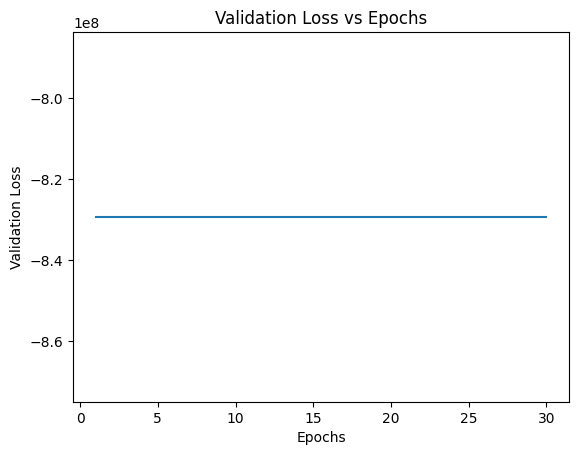

In [44]:
# 获取最佳模型的训练损失
best_index = grid_result.best_index_
validation_loss = results_df.loc[best_index, "mean_test_score"]

# 绘制验证损失与 epoch 的关系图
plt.plot(range(1, grid_result.best_params_['epochs'] + 1), [validation_loss] * grid_result.best_params_['epochs'])
plt.title("Validation Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.savefig("validation_loss_vs_epochs.png")
plt.show()


In [42]:
best_history

In [38]:
validation_loss

-829344000.0

In [45]:
# 打印最佳配置
print("Best parameters found by GridSearchCV:")
print(grid_result.best_params_)


Best parameters found by GridSearchCV:
{'batch_size': 32, 'dense_layer_sizes': (128, 64), 'embedding_dim': 16, 'epochs': 30, 'learning_rate': 0.0005}


In [48]:
import numpy as np
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

# 将特征数据拼接成单一矩阵
train_features = np.hstack([train_sme_ban.values.reshape(-1, 1), train_sme_ban_features, train_solution_uuid.values.reshape(-1, 1), train_solution_uuid_features])

param_grid = {
    'embedding_dim': [16],
    'dense_layer_sizes': [(128, 64)],
    'activation': ['relu', 'tanh', 'sigmoid'],  # Add activation function as a hyperparameter
    'learning_rate': [0.0005, 0.001],
    'epochs': [30,40],
    'batch_size': [32, 64],
}
# 定义创建模型的函数
def create_model(embedding_dim=8, dense_layer_sizes=(128, 64), learning_rate=0.001, activation='relu'):
    # SME_BAN 输入
    sme_ban_input = Input(shape=(1,), name='sme_ban_input')
    sme_ban_embedding = Embedding(input_dim=train_sme_ban.max() + 2, output_dim=embedding_dim, mask_zero=True, name='sme_ban_embedding')(sme_ban_input)
    sme_ban_vec = Flatten()(sme_ban_embedding)

    sme_ban_features_input = Input(shape=(len(sme_ban_columns),), name='sme_ban_features_input')
    sme_ban_combined = Concatenate()([sme_ban_vec, sme_ban_features_input])

    # Solution_UUID 输入
    solution_uuid_input = Input(shape=(1,), name='solution_uuid_input')
    solution_uuid_embedding = Embedding(input_dim=train_solution_uuid.max() + 2, output_dim=embedding_dim, mask_zero=True, name='solution_uuid_embedding')(solution_uuid_input)
    solution_uuid_vec = Flatten()(solution_uuid_embedding)

    solution_uuid_features_input = Input(shape=(len(solution_uuid_columns),), name='solution_uuid_features_input')
    solution_uuid_combined = Concatenate()([solution_uuid_vec, solution_uuid_features_input])

    # 将用户和物品组合在一起
    combined = Concatenate()([sme_ban_combined, solution_uuid_combined])

    # 添加全连接层
    dense = Dense(dense_layer_sizes[0], activation=activation)(combined)
    dense = Dense(dense_layer_sizes[1], activation=activation)(dense)

    # 输出层：预测 total_pay
    total_pay_output = Dense(1, activation='linear', name='total_pay_output')(dense)

    # 创建模型
    model = Model(inputs=[sme_ban_input, sme_ban_features_input, solution_uuid_input, solution_uuid_features_input], outputs=[total_pay_output])

    # 编译模型
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    
    return model



In [ ]:
# 创建 KerasRegressor
model = CustomKerasRegressor(build_fn=create_model)

# 创建网格搜索
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)

# 拟合数据
grid_result = grid.fit(train_features, train_interactions.values)

# 检查最佳参数组合
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))